# Replication of the two-asset model in Auclert, Rognile and Straub  (2020)* with sticky information.

*Auclert, Adrien, Matthew Rognlie, and Ludwig Straub. Micro jumps, macro humps: Monetary policy and business cycles in an estimated HANK model. No. w26647. National Bureau of Economic Research, 2020.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from HANKStickyModel import HANKStickyModelClass

# Replication settings

In [2]:
import os

replication_settings = {
    'savefolder': os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + 'saved_models'),   # if empty, the usual "saved" folder is used
    'update_par': {     # updates par for all models
    },
}

# update parameters for
updated_par=replication_settings['update_par']

In [3]:
def solution_routine(model, do_print=False, do_direct=False):
    """ solve model and find IRF"""
    # find steady state
    print(f'Find steady state for {model.name}')
    model.find_ss(do_print=do_print)
    # compute jacs using fake news method
    print(f'Compute jacs for {model.name}')
    model.compute_jacs(do_print=do_print, do_direct=do_direct)
    # find transition paths
    print(f'Find transition path for {model.name}')
    model.find_transition_path(do_print=do_print, do_print_unknowns=do_print, do_end_check=False)
    # find IRFs
    print(f'Find IRFs for {model.name}')
    model.find_IRFs(do_print=do_print)

# Solve baseline model

In [4]:
model = HANKStickyModelClass(name='baseline', par=updated_par, savefolder=replication_settings['savefolder'])
solution_routine(model, do_print=True)

Find steady state for baseline
Find optimal beta for market clearing
final evaluation
household problem in ss solved in 0.9 secs [482 iterations]
household problem in ss simulated in 0.3 secs [506 iterations]
steady state found in 23.4 secs
 beta   = 0.9835
 nu     = 259.1461
Discrepancy in A =  -0.00000000
Discrepancy in L =   0.00000000
Discrepancy in Y =  -0.00000000
Compute jacs for baseline
household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for Z               in 0.7 secs
curly_Y and curly_D calculated for ez              in 0.7 secs
curly_Y and curly_D calculated for ra              in 0.7 secs
curly_Y and curly_D calculated for rl              in 0.7 secs
curly_E calculated in 1.8 secs
builiding blocks combined in 0.2 secs
household Jacobian computed in 4.6 secs

full Jacobians:
full Jacobian to unknowns computed in 9.8 secs [in evaluate_path(): 9.5 secs]
full Jacobian to shocks computed in 0.3 secs [in evaluate_path()

# Sticky information

## Init sticky information model.

In [5]:
updated_par = {**replication_settings['update_par'], **{'inattention': 0.935}}
# init model
model_sticky = HANKStickyModelClass(name='sticky_information', par=updated_par)
# solve model
solution_routine(model_sticky, do_print=True)

Find steady state for sticky_information
Find optimal beta for market clearing
final evaluation
household problem in ss solved in 0.9 secs [482 iterations]
household problem in ss simulated in 0.3 secs [506 iterations]
steady state found in 23.4 secs
 beta   = 0.9835
 nu     = 259.1461
Discrepancy in A =  -0.00000000
Discrepancy in L =   0.00000000
Discrepancy in Y =  -0.00000000
Compute jacs for sticky_information
household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for Z               in 0.7 secs
curly_Y and curly_D calculated for ez              in 0.7 secs
curly_Y and curly_D calculated for ra              in 0.7 secs
curly_Y and curly_D calculated for rl              in 0.7 secs
curly_E calculated in 0.4 secs
builiding blocks combined in 0.2 secs
household Jacobian computed in 3.3 secs
household inattention = 0.935

full Jacobians:
full Jacobian to unknowns computed in 9.3 secs [in evaluate_path(): 9.0 secs]
full Jacobian 

##  Fake news algorithm vs. direct method
Look at the household Jacobians for the sticky information. Note that the Jacobians based on the direct method are not correct.

note: differences should only be due to numerical errors

household inattention = 0.935
-> sticky information jacs based on direct method wont be correct
direct method:
finding Jacobian wrt. ghost          : 0 50 100 150 [computed in 3.3 secs]
finding Jacobian wrt. Z              : 0 50 100 150 [computed in 1.3 secs]
finding Jacobian wrt. ez             : 0 50 100 150 [computed in 1.3 secs]
finding Jacobian wrt. ra             : 0 50 100 150 [computed in 1.3 secs]
finding Jacobian wrt. rl             : 0 50 100 150 [computed in 1.3 secs]
household Jacobian computed in 8.4 secs

fake news method:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for Z               in 0.7 secs
curly_Y and curly_D calculated for ez              in 0.7 secs
curly_Y and curly_D calculated for ra              in 0.7 secs
curly_Y and curly_D calculated for rl              in 0.7 secs
curly_E calculated in 0.4 secs
builiding blocks combined in 0.2 secs
household Jacobi

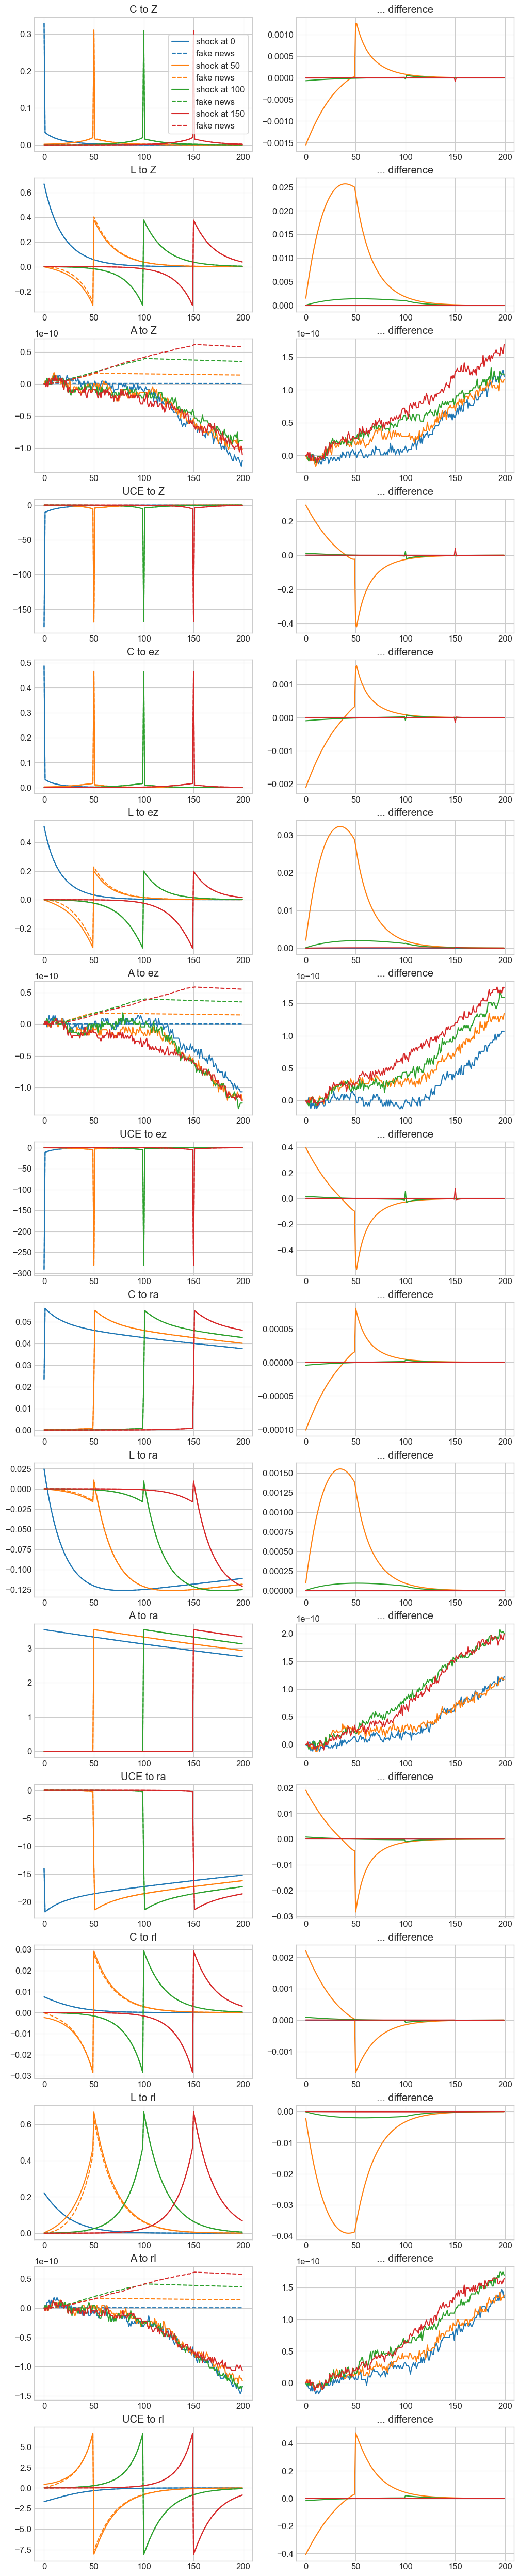

In [6]:
model_sticky.test_jacs()

In [7]:
# model_sticky.test_jacs_sticky()

Direct method should not be correct, as the household problem is not formulated accordingly. It should correspond to the solution without sticky information.
Double check if that is the case:

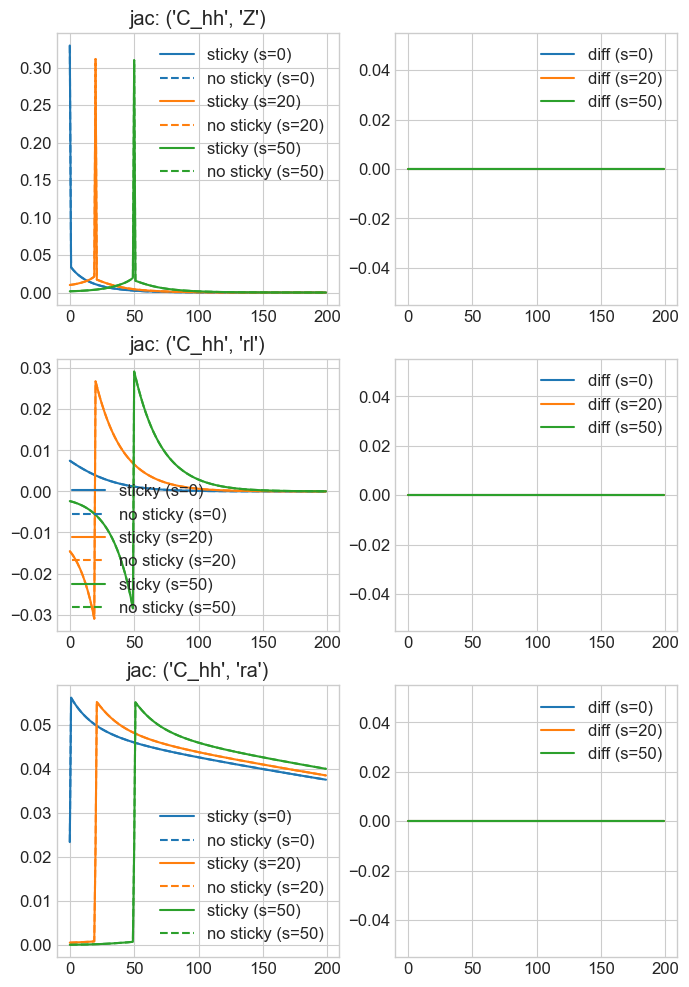

In [8]:
s_list = [0, 20, 50]

# hh_jacs with and without fake news algorithm
model_sticky._compute_jac_hh(dx=1e-4,do_print=False,do_direct=True, s_list=s_list)

model._compute_jac_hh(dx=1e-4,do_print=False,do_direct=True, s_list=s_list)

par = model_sticky.par

compare_outputs = ['C_hh']
compare_inputs = ['Z', 'rl', 'ra']

ncols = 2
nrows = len(compare_inputs)*len(compare_outputs)

fig = plt.figure(figsize=(4*ncols, 4*nrows))

fig_i = 0
for output in compare_outputs:
    for input in compare_inputs:
        fig_i += 1
        ax1 = fig.add_subplot(nrows, ncols, fig_i)
        fig_i += 1
        ax2 = fig.add_subplot(nrows, ncols, fig_i)

        jac_name = (output, input)

        for (j, s) in enumerate(s_list):
            diff = model.jac_hh[jac_name][:,s] - model_sticky.jac_hh[jac_name][:,s]
            ax1.plot(np.arange(par.T),model_sticky.jac_hh[jac_name][:,s],color=colors[j],ls='-',label=f'sticky (s={s})')
            ax1.plot(np.arange(par.T),model.jac_hh[jac_name][:,s],color=colors[j],ls='--',label=f'no sticky (s={s})')
            ax1.set_title(f'jac: {jac_name}')
            ax2.plot(np.arange(par.T),diff,color=colors[j],label=f'diff (s={s})')
        ax1.legend()
        ax2.legend()

In [9]:
# use fake news jacs from here on out and compute full jacs
model_sticky.compute_jacs(dx=1e-4,do_print=False,do_direct=False,parallel=True)
# jacs_hh_fake_news = model_sticky.jac_hh.copy()
model._compute_jac_hh(dx=1e-4,do_print=False,do_direct=False)
# jacs_hh_fake_news = model_sticky.jac_hh.copy()

household inattention = 0.935


## Check for sluggish response
See if there is a sluggish response of consumption in the sticky information case.
In Auclert et al. This shows the different general equilibrium responses to a persistent income shock.
<img src="images\\IRF_Auclert_Z.png" alt="DAG Humps, Jumps" width=400 height=300 />

Note by Auclert et al. for the theta = 0 case:
"The consumption response has a counterfactual peak on impact. The reason is that, even though the response of investment is delayed, perfectly attentive households have enough liquidity to bring forward spending in anticipation of future changes in real interest rates and income."

### Partial Equilibrium responses
Compare the reaction from household Jacobians to an isolated shock to an input. So this is equivalent to a partial equilibrium response.

In [10]:
def plot_PE_hh(model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho):

    nrows = len(compare_outputs)
    ncols = len(compare_inputs)

    fig = plt.figure(figsize=(4*ncols, 4*nrows), dpi=100)
    fig_i = 0
    for output in compare_outputs:
        for i_s, shock in enumerate(compare_inputs):

            shock_series =  shocks_jump[i_s]*shocks_rho[i_s]**np.arange(par.T)

            fig_i += 1
            ax = fig.add_subplot(nrows, ncols, fig_i)
            ax.set_title(f'{shock}_shock on {output} (in %)')

            for i_m, m in enumerate(model_list):
                IRF_abs = m.jac_hh[(output, shock)] @ shock_series
                IRF_perc = (IRF_abs / m.ss.__dict__[output]) * 100
                # plot
                ax.plot(np.arange(plot_periods), IRF_perc[:plot_periods], label=label_list[i_m])
            ax.legend()

#### P.E. responses to persistent shocks

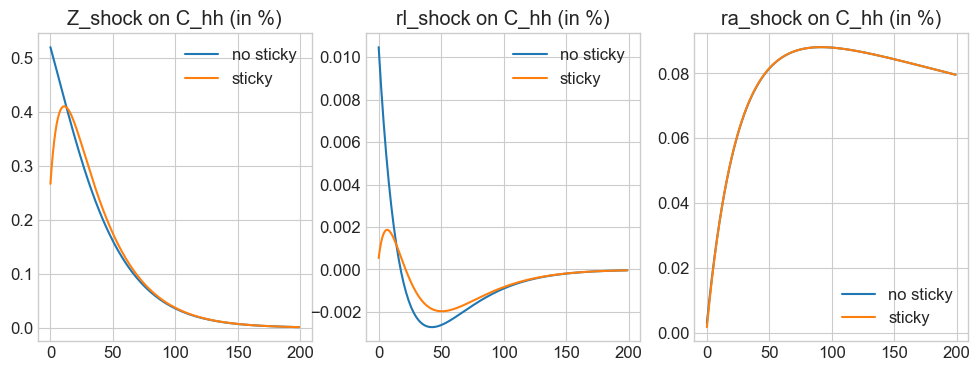

In [11]:
model_list = [model, model_sticky]
label_list = ['no sticky', 'sticky']

compare_outputs = ['C_hh']
compare_inputs = ['Z', 'rl', 'ra']

plot_periods = model.par.T

# 1 % jump in income
ss = model_sticky.ss

shocks_jump = [0.01 * ss.Z, 0.01 * ss.rl, 0.01 * ss.ra]
shocks_rho =[0.966, 0.966, 0.966]

plot_PE_hh(model_list, label_list, compare_outputs, compare_inputs, plot_periods, shocks_jump, shocks_rho)

This reaction describes the partial equilibrium household response to permanent shocks in their inputs.
The first graph (Z_shock) would thus indicate the reaction to a permanent increase in after tax-labor income. The hump-shaped response is clearly visible.

#### P.E. responses to one-time shocks
--> See household Jacobians

### General Equilibrium response
Now the full equilibrium response

In [12]:
# paths = ['Z', 'Y', 'C_hh']
# lvl_value = ['eg', 'em', 'ez']
paths = ['G', 'Y', 'C_hh', 'K', 'I', 'Z',
         'N', 'w', 'tau', 'Pi', 'Pi_w', 'i', 's', 's_w',
         'L_hh', 'A_hh',
         'rk', 'r','ra', 'rl',
         'q', 'B',
         'p_eq', 'Div', 'p_int', 'Div_int', 'p_k', 'Div_k']
paths_short = ['Y', 'C_hh', 'K', 'I', 'N', 'w']
lvl_value = ['eg', 'em', 'ez', 'i', 'Pi', 'Pi_w']
abs_diff = ['r', 'ra', 'rl', 'i']
facs = {'r':100,'ra':100,'rl':100}

# sticky infomration model
model_sticky.par.jump_ez = 0.001 * model_sticky.ss.Z
model_sticky.par.rho_ez = 0.9 # 0.966
model_sticky.par.jump_em = 0.0
model_sticky.par.rho_em = 0.0
model_sticky.find_transition_path(do_end_check=False)
model_sticky.find_IRFs()
# no sticky model
model.par.jump_ez = 0.001 * model_sticky.ss.Z
model.par.rho_ez = 0.9
model.par.jump_em = 0.0
model.par.rho_em = 0.0
model.find_transition_path(do_end_check=False)
model.find_IRFs()

### shocks ###


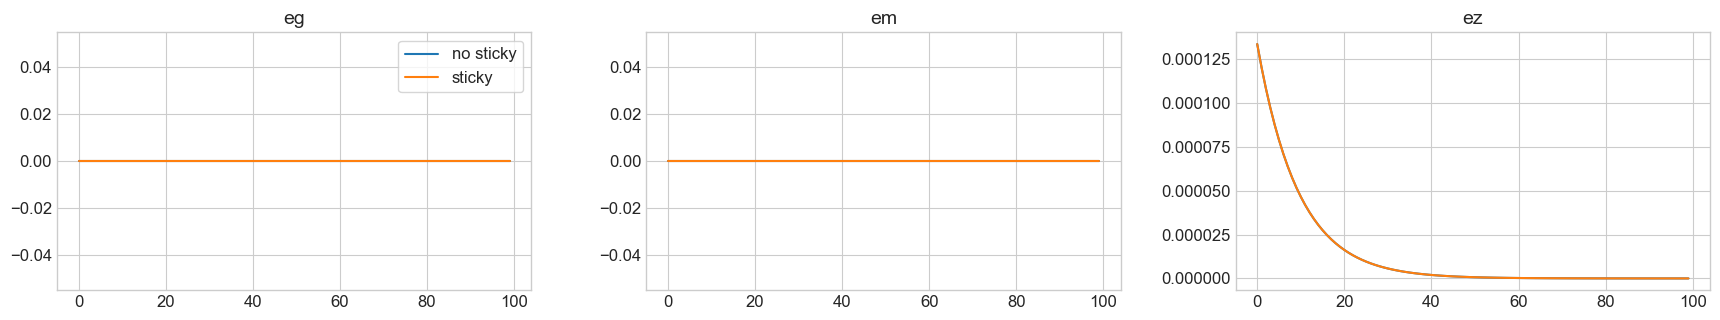


### varnames ###


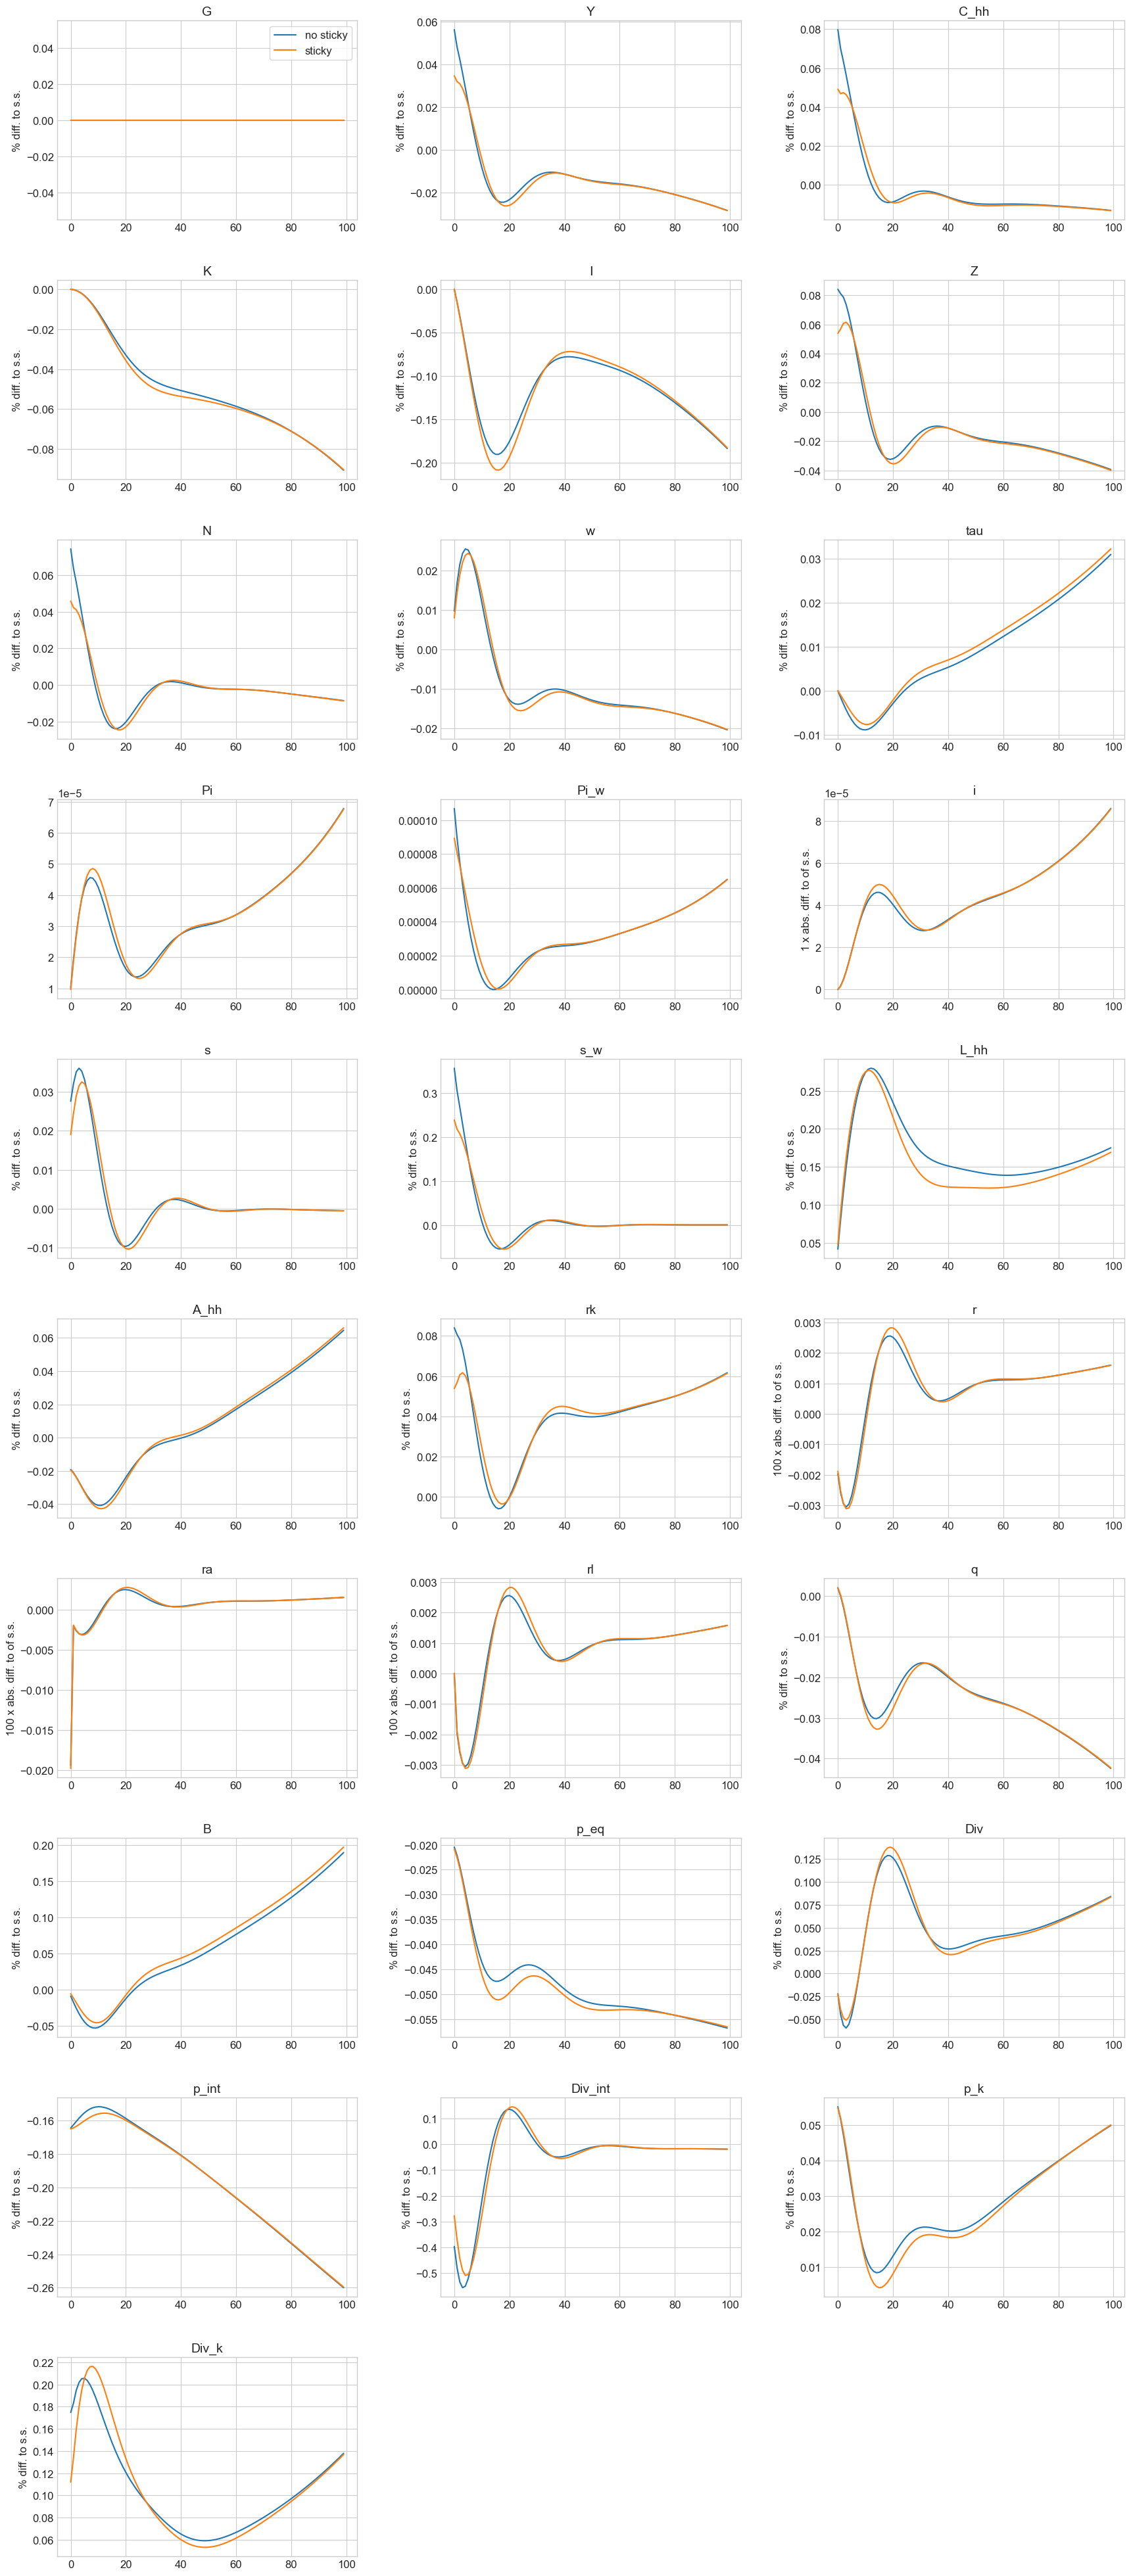


### tagets ###


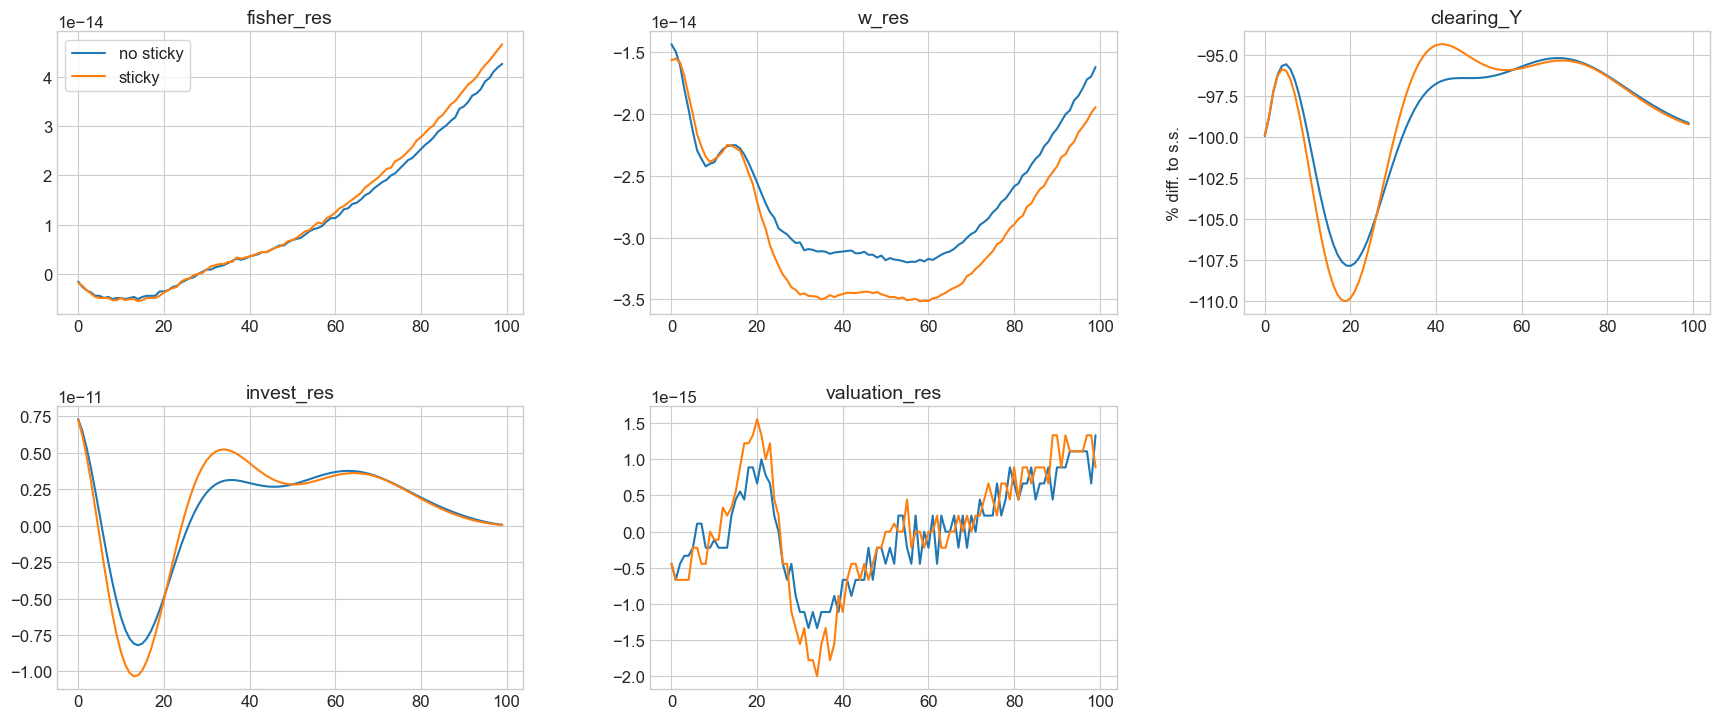

In [13]:
labels_list = ['no sticky', 'sticky']
models_list = [model, model_sticky]
model.compare_IRFs(models_list, labels_list, paths, lvl_value=lvl_value, abs_diff=abs_diff, facs=facs,ncols=3,T_max=100)

In [14]:
path = model.path
ss = model.ss
par = model.par

In [15]:
A_hh_lag = np.hstack([ss.A_hh, path.A_hh[0, :-1]])
L_hh_lag = np.hstack([ss.L_hh, path.L_hh[0, :-1]])
B_lag = np.hstack([ss.B, path.B[0, :-1]])

# beginning of period constraint
LHS = (1 + path.ra[0]) * A_hh_lag + (1 + path.rl[0]) * L_hh_lag
RHS = (1 + par.delta_q * path.q[0]) * B_lag + path.p_eq[0] + path.Div[0] - par.xi * L_hh_lag
LHS - RHS

array([0.        , 0.00013521, 0.00025854, 0.00037121, 0.0004743 ,
       0.0005688 , 0.00065559, 0.00073545, 0.00080912, 0.00087723,
       0.00094036, 0.00099904, 0.00105374, 0.00110487, 0.00115282,
       0.00119793, 0.00124051, 0.00128084, 0.00131915, 0.00135568,
       0.00139063, 0.00142418, 0.0014565 , 0.00148772, 0.001518  ,
       0.00154745, 0.00157618, 0.00160428, 0.00163185, 0.00165897,
       0.00168572, 0.00171215, 0.00173833, 0.00176432, 0.00179015,
       0.00181589, 0.00184157, 0.00186722, 0.00189288, 0.00191859,
       0.00194436, 0.00197023, 0.00199622, 0.00202234, 0.00204863,
       0.00207509, 0.00210175, 0.00212862, 0.00215571, 0.00218305,
       0.00221063, 0.00223847, 0.00226658, 0.00229498, 0.00232367,
       0.00235266, 0.00238196, 0.00241158, 0.00244153, 0.00247181,
       0.00250243, 0.00253341, 0.00256473, 0.00259642, 0.00262848,
       0.00266092, 0.00269373, 0.00272694, 0.00276054, 0.00279454,
       0.00282894, 0.00286376, 0.002899  , 0.00293466, 0.00297

In [16]:
# end of the period constraint
path.A_hh[0] + path.L_hh[0] - path.qB[0] - path.p_eq[0]

array([0.00013357, 0.00025541, 0.00036672, 0.00046857, 0.00056192,
       0.00064765, 0.00072655, 0.00079932, 0.0008666 , 0.00092897,
       0.00098693, 0.00104096, 0.00109146, 0.00113883, 0.00118339,
       0.00122545, 0.00126528, 0.00130313, 0.00133921, 0.00137374,
       0.00140688, 0.0014388 , 0.00146966, 0.00149957, 0.00152866,
       0.00155704, 0.00158481, 0.00161205, 0.00163884, 0.00166526,
       0.00169138, 0.00171724, 0.00174292, 0.00176844, 0.00179387,
       0.00181923, 0.00184458, 0.00186993, 0.00189532, 0.00192078,
       0.00194633, 0.00197201, 0.00199781, 0.00202378, 0.00204992,
       0.00207626, 0.0021028 , 0.00212956, 0.00215656, 0.00218381,
       0.00221131, 0.00223908, 0.00226714, 0.00229548, 0.00232412,
       0.00235306, 0.00238232, 0.00241191, 0.00244182, 0.00247207,
       0.00250266, 0.00253361, 0.00256492, 0.00259659, 0.00262863,
       0.00266104, 0.00269385, 0.00272704, 0.00276063, 0.00279461,
       0.00282901, 0.00286382, 0.00289905, 0.00293471, 0.00297

As the

# MP shock response

In [17]:
paths = ['G', 'Y', 'C_hh', 'K', 'I',
         'N', 'w', 'tau', 'Pi', 'Pi_w', 'i', 's', 's_w',
         'L_hh', 'A_hh',
         'rk', 'r','ra', 'rl',
         'q', 'B',
         'p_eq', 'Div', 'p_int', 'Div_int', 'p_k', 'Div_k']
paths_short = ['Y', 'C_hh', 'K', 'I', 'N', 'w']
lvl_value = ['eg', 'em', 'i', 'Pi', 'Pi_w']
abs_diff = ['r', 'ra', 'rl', 'i']
facs = {'r':100,'ra':100,'rl':100}

### shocks ###


C:\Users\Yannik\Meine Ablage\Uni\Master\Master Thesis\Thesis_Code\Hump_Jump_Replication\GEModelTools\figures.py:123: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(np.arange(T_max),100*(pathvalue[:T_max]/ssvalue-1),label=label)


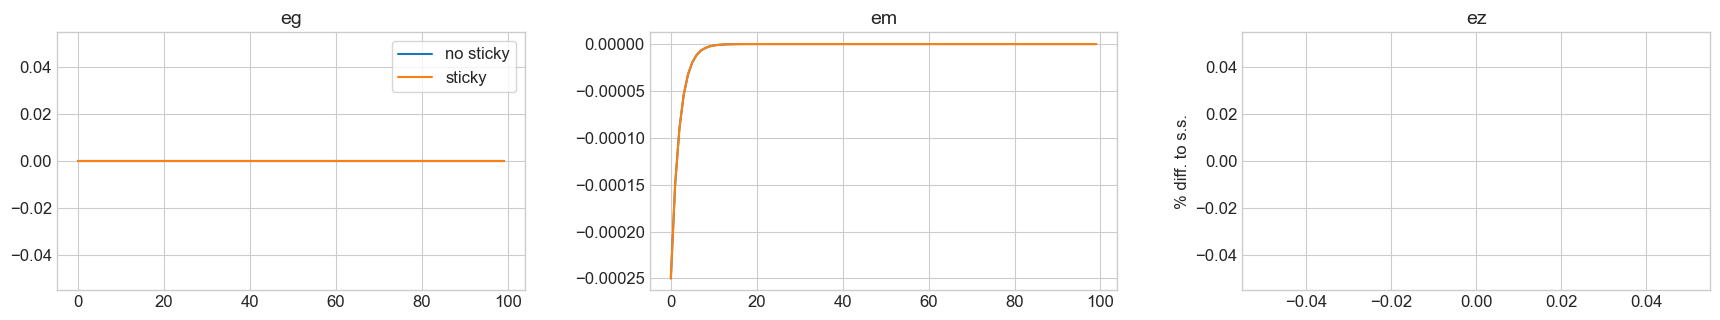


### varnames ###


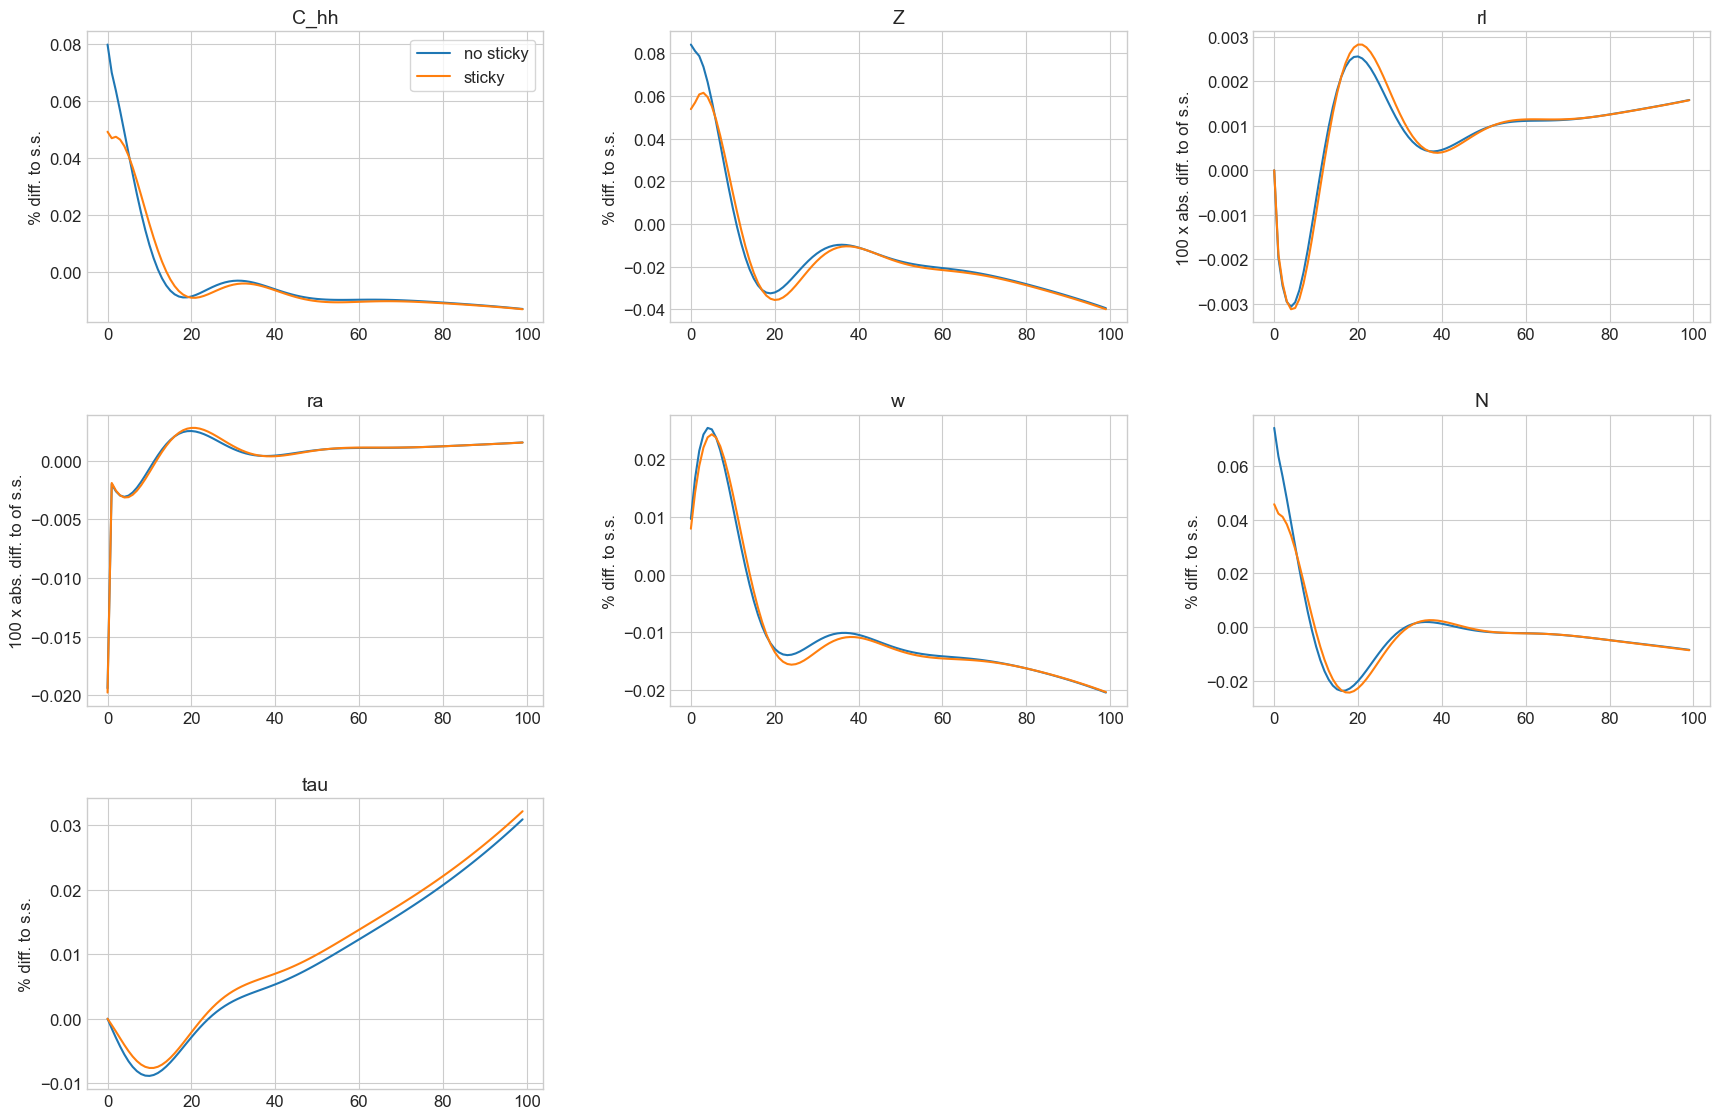


### tagets ###


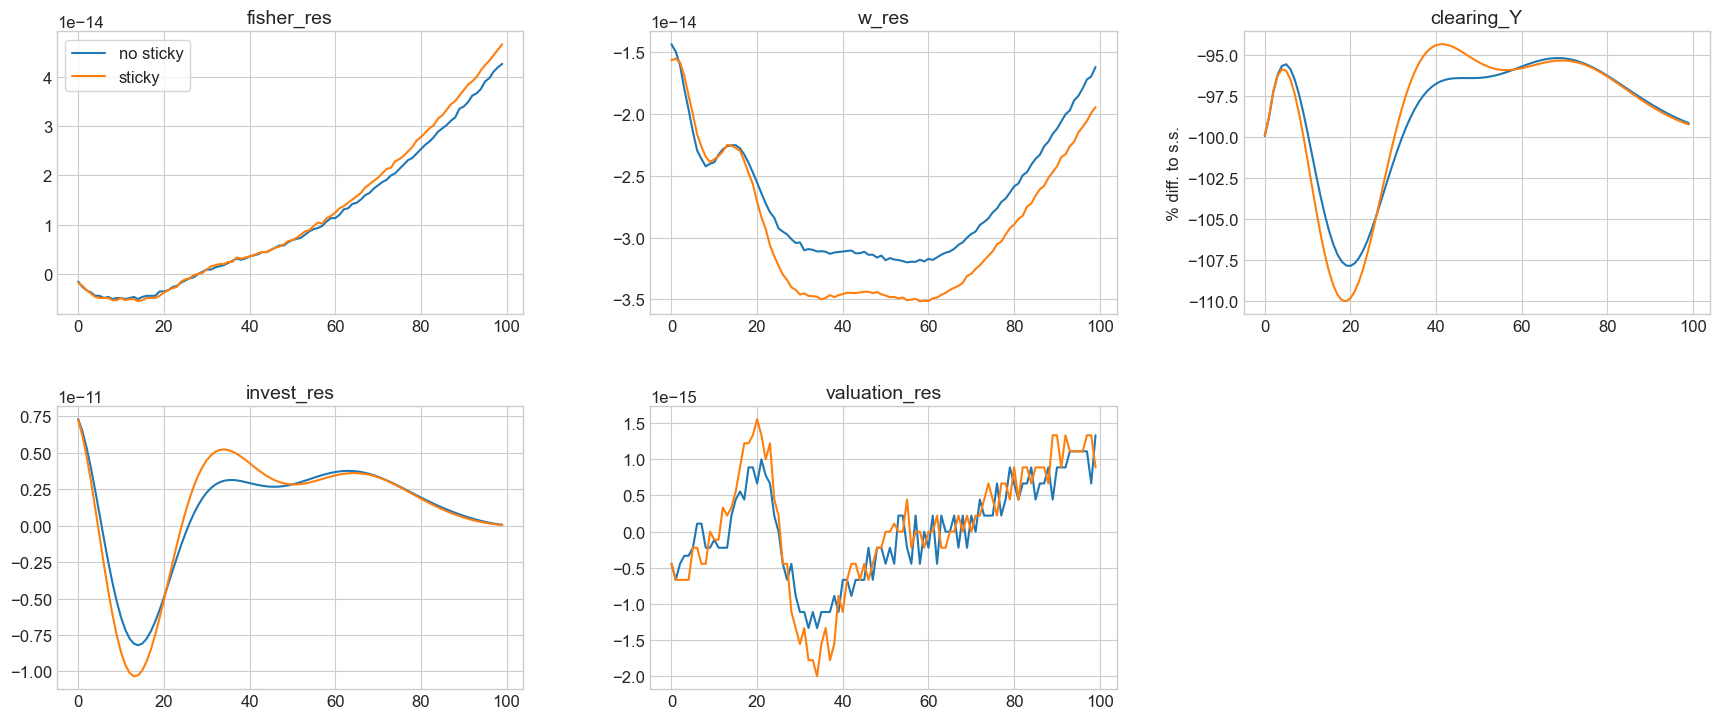

In [18]:
shock_settings = {
                'jump_em': -0.00025,
                'rho_em': 0.6,
                'jump_eg': 0.
            }

model.par.jump_em = shock_settings['jump_em']
model.par.rho_em = shock_settings['rho_em']
model.par.jump_eg = shock_settings['jump_eg']
model.find_IRFs()

model_sticky.par.jump_em = shock_settings['jump_em']
model_sticky.par.rho_em = shock_settings['rho_em']
model_sticky.par.jump_eg = shock_settings['jump_eg']
model_sticky.find_IRFs()

paths_inputs = ['C_hh', 'Z', 'rl', 'ra', 'w', 'N', 'tau']
labels_list = ['no sticky', 'sticky']
models_list = [model, model_sticky]
model.compare_IRFs(models_list, labels_list, paths_inputs, lvl_value=lvl_value, abs_diff=abs_diff, facs=facs,ncols=3,T_max=100)


## Investigate further

NameError: name 'IRF_sticky' is not defined

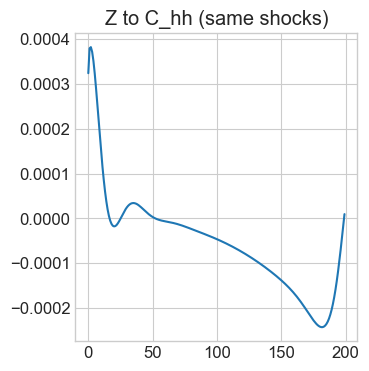

In [19]:
jac_name = ('C_hh', 'Z')

shock_series_no_sticky = model.IRF['Z']
shock_series_sticky = model_sticky.IRF['Z']

IRF_no_sticky = model.jac_hh[jac_name] @ shock_series_no_sticky
IRF_sticky_shock_no_sticky = model_sticky.jac_hh[jac_name] @ shock_series_no_sticky
IRF_sticky_shock_sticky = model_sticky.jac_hh[jac_name] @ shock_series_sticky

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,2,1)
ax.set_title(f'Z to C_hh (same shocks)')
ax.plot(np.arange(par.T), IRF_no_sticky, label='no sticky')
ax.plot(np.arange(par.T), IRF_sticky, label='sticky')
ax.legend()

ax = fig.add_subplot(1,2,2)
ax.set_title(f'Z to C_hh (endo. shocks)')
ax.plot(np.arange(par.T), IRF_no_sticky, label='no sticky')
ax.plot(np.arange(par.T), IRF_sticky_shock_sticky, label='sticky')
ax.legend()

In [ ]:
labels_list = ['no sticky', 'sticky']
models_list = [model, model_sticky]
model.compare_IRFs(models_list, labels_list, paths_short, lvl_value=lvl_value, abs_diff=abs_diff, facs=facs,ncols=3,T_max=100,
                   do_linear=True, do_non_linear=False)

### plot more variables

In [ ]:
model_sticky.par.jump_em = shock_settings['jump_em']
model_sticky.par.rho_em = shock_settings['rho_em']
model_sticky.par.jump_eg = shock_settings['jump_eg']
model_sticky.find_IRFs()
labels_list = ['no sticky', 'sticky']
models_list = [model, model_sticky]
model.compare_IRFs(models_list, labels_list, paths, lvl_value=lvl_value, abs_diff=abs_diff, facs=facs,ncols=3,T_max=100,
                   do_linear=True, do_non_linear=False)